# Almgren-Chriss Framework – Quadratic Execution Costs

## Objective
Implement the **original Almgren-Chriss (2001)** optimal execution model in its **simplest and most elegant form**:
- **Quadratic execution costs**: $ L(\rho) = \eta \rho^2 $, where $ \rho = \frac{|v_t|}{V} $
- **Constant market volume** $ V $
- **Closed-form analytical solution** using hyperbolic functions

This notebook applies the model to both:
1. **Stock market data** (if available from S3)
2. **Cryptocurrency data** (always available via Binance API)

---

## Model (Almgren-Chriss, 2001)

### Price Dynamics (with Permanent Impact)
$$
dS_t = \sigma \, dW_t + b \, v_t \, dt
$$
> $ v_t = \dot{q}_t $: trading speed  
> $ b $: permanent impact coefficient  
> $ \sigma $: annualized volatility

### Execution Costs (Temporary / Instantaneous Impact)
$$
L(\rho) = \eta \rho^2, \quad \rho_t = \frac{|v_t|}{V}
$$

### Optimization Objective
$$
\min_{v_t} \quad \mathbb{E}\left[ X_T \right] + \frac{\lambda}{2} \operatorname{Var}\left[ X_T \right]
$$

### Optimal Trajectory (Closed-Form Solution)
$$
\boxed{
q^*(t) = q_0 \frac{\sinh \left( \kappa (T - t) \right)}{\sinh (\kappa T)}
}
\quad \text{with} \quad
\boxed{
\kappa = \sqrt{\frac{\lambda \sigma^2 V}{2 \eta}}
}
$$

## Setup

In [140]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add src to path for imports
sys.path.insert(0, str(Path('.').resolve().parent))

# Import from our modules
from src.models import AlmgrenChrissModel, MarketParameters, ImpactParameters
from src.optimization import TWAP, VWAP, OptimalAC, ExecutionParams, ImpactParams

# Graphics configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Create results directory
Path('results').mkdir(exist_ok=True)

print(" Imports successful (using src modules)")

 Imports successful (using src modules)


## Load Market Data & Parameters

In [141]:
# Load market parameters
df_params = pd.read_parquet('data/processed/market_parameters.parquet')

# Try to load calibrated parameters
try:
    with open('../results/calibrated_parameters.json', 'r') as f:
        calibrated = json.load(f)
    
    calibrated_available = True
    print(" Calibrated parameters loaded from results/calibrated_parameters.json")
    print(f"   Calibrated on: {calibrated.get('timestamp', 'N/A')}")
    print(f"   Symbol: {calibrated.get('symbol', 'N/A')}")
    print(f"   Number of snapshots: {calibrated.get('num_snapshots', 'N/A')}")
except FileNotFoundError:
    calibrated_available = False
    print("️ No calibrated parameters found")
    print("   Run notebook 06_parameter_calibration.ipynb first to calibrate parameters")
    print("   Using literature-based parameters as fallback")

# Check which data is available
stocks_available = os.path.exists('data/processed/stocks/all_stocks_1m.parquet')
crypto_available = len(df_params[df_params['asset_type'] == 'crypto']) > 0

print("\n Available data:")
print(f"   Stocks: {' Yes' if stocks_available else ' No'}")
print(f"   Crypto: {' Yes' if crypto_available else ' No'}")
print(f"   Calibrated params: {' Yes' if calibrated_available else ' No'}")
print(f"\nThis notebook will execute on: {'stocks and crypto' if stocks_available and crypto_available else 'crypto only' if crypto_available else 'ERROR: no data'}")

 Calibrated parameters loaded from results/calibrated_parameters.json
   Calibrated on: 2025-12-27T21:01:29.925212
   Symbol: BTCUSDT
   Number of snapshots: 360

 Available data:
   Stocks:  No
   Crypto:  Yes
   Calibrated params:  Yes

This notebook will execute on: crypto only


## Almgren-Chriss Model Class

In [142]:
# =============================================================================
# ALMGREN-CHRISS QUADRATIC MODEL CLASS
# =============================================================================

class AlmgrenChrissQuadratic:
    """
    Almgren-Chriss (2001) model with QUADRATIC execution costs.
    
    This is the ORIGINAL AC model with analytical (closed-form) solution.
    
    Cost Model (Almgren-Chriss 2001):
    ---------------------------------
    The instantaneous execution cost is:
        g(v) = η × v²/V
    
    where v = dq/dt is the trading rate and V is daily volume.
    
    In terms of participation rate ρ = |v|/V:
        g(v) = η × V × ρ²
    
    The TOTAL execution cost over [0,T] is:
        ∫₀ᵀ g(v) dt = ∫₀ᵀ η × v²/V dt
    
    For TWAP (v = q₀/T constant):
        Execution Cost = η × (q₀/T)² / V × T = η × q₀² / (V×T)
    
    Permanent Impact:
    -----------------
    Price impact: ΔS = γ × q₀
    Cost = (1/2) × γ × q₀² (average impact over trajectory)
    
    In relative terms: k = γ/S₀, so:
        Permanent Cost = k × q₀² / 2
    
    Units:
    ------
    All costs are returned in units that, when multiplied by S₀, give dollars.
    - To convert to bps: (cost / q₀) × 10000
    - To convert to dollars: cost × S₀
    """
    
    def __init__(self, lambda_risk, sigma, k, eta, V, psi=0.0, S0=None):
        """
        Initialize the Almgren-Chriss quadratic model.
        
        Parameters:
        -----------
        lambda_risk : float
            Risk aversion parameter
        sigma : float
            Annualized volatility (as fraction, e.g., 0.50 for 50%)
        k : float
            Permanent impact coefficient (relative)
            Calibrated so that k × q₀ = relative price impact
        eta : float
            Temporary impact coefficient for QUADRATIC model
            Calibrated so that slippage = η × ρ for participation rate ρ
        V : float
            Daily volume (in units of asset)
        psi : float
            Fixed costs (fees + spread) as fraction (e.g., 0.001 = 10 bps)
        S0 : float, optional
            Current price (for dollar conversions)
        """
        self.lambda_risk = lambda_risk
        self.sigma = sigma
        self.k = k
        self.eta = eta
        self.V = V
        self.psi = psi
        self.S0 = S0 if S0 else 1.0
    
    def compute_kappa(self):
        """
        Compute the urgency parameter κ.
        
        κ = sqrt(λσ²V / (2η))
        
        Large κ → execute quickly (high urgency)
        Small κ → execute slowly (close to TWAP)
        """
        return np.sqrt(self.lambda_risk * self.sigma**2 * self.V / (2 * self.eta))
    
    def optimal_trajectory(self, q0, T, N=390):
        """
        Compute the optimal trajectory q*(t) and trading rate v*(t).
        
        Analytical solution (Almgren-Chriss 2001):
        q*(t) = q0 × sinh(κ(T-t)) / sinh(κT)
        v*(t) = -q0 × κ × cosh(κ(T-t)) / sinh(κT)
        """
        kappa = self.compute_kappa()
        t = np.linspace(0, T, N+1)
        
        # Handle numerical issues for large κT
        if kappa * T > 100:
            q_star = q0 * np.exp(-kappa * (t - 0))
            v_star = -q0 * kappa * np.exp(-kappa * (t - 0))
        elif kappa * T < 0.01:
            q_star = q0 * (1 - t / T)
            v_star = -q0 / T * np.ones_like(t)
        else:
            q_star = q0 * np.sinh(kappa * (T - t)) / np.sinh(kappa * T)
            v_star = q0 * (-kappa) * np.cosh(kappa * (T - t)) / np.sinh(kappa * T)
        
        return t, q_star, v_star
    
    def compute_costs(self, q0, T, N, strategy='optimal'):
        """
        Compute execution costs for a given strategy.
        
        Cost Components (Almgren-Chriss 2001):
        --------------------------------------
        1. Transaction fees: ψ × |q₀|
        
        2. Temporary impact: ∫ η × v²/V dt
           - For TWAP: η × q₀² / (V × T)
           - This is the cost from moving the price temporarily
        
        3. Permanent impact: k × q₀² / 2
           - Average cost from permanent price change
           - We pay full impact at start (k×q₀), none at end, average = k×q₀/2
        
        4. Timing risk: (λ/2) × σ² × ∫ q² dt
           - Penalty for holding risky position over time
        
        Returns:
        --------
        dict with costs. Multiply by S₀ to get dollars.
        """
        if strategy == 'optimal':
            t, q, v = self.optimal_trajectory(q0, T, N)
        elif strategy in ['twap', 'vwap']:
            t = np.linspace(0, T, N+1)
            q = q0 * (1 - t / T)
            v = -(q0 / T) * np.ones_like(t)
        else:
            raise ValueError(f"Unknown strategy: {strategy}")
        
        dt = T / N
        
        # =====================================================================
        # 1. TRANSACTION FEES: ψ × |q₀|
        # =====================================================================
        transaction_fees = self.psi * abs(q0)
        
        # =====================================================================
        # 2. TEMPORARY IMPACT: ∫ η × v²/V dt
        # =====================================================================
        # This is the AC2001 formulation: instantaneous cost = η × v² / V
        # Integrating: ∫ η × v² / V dt
        # 
        # For TWAP with v = q₀/T constant:
        #   = η × (q₀/T)² / V × T = η × q₀² / (V × T)
        #
        # Note: We DON'T divide by V twice! The formula is η×v²/V, not η×(v/V)²
        execution_cost = np.sum(self.eta * v[:-1]**2 / self.V * dt)
        
        # =====================================================================
        # 3. PERMANENT IMPACT: k × q₀² / 2
        # =====================================================================
        # The price moves by k × q₀ permanently
        # Average cost over trajectory = k × q₀² / 2 (triangular)
        permanent_impact = self.k * q0**2 / 2
        
        # =====================================================================
        # 4. TIMING RISK: (λ/2) × σ² × ∫ q² dt
        # =====================================================================
        timing_risk_variance = self.sigma**2 * np.sum(q[:-1]**2 * dt)
        timing_risk = (self.lambda_risk / 2) * timing_risk_variance
        
        # =====================================================================
        # TOTAL COST
        # =====================================================================
        total_cost = transaction_fees + execution_cost + permanent_impact + timing_risk
        
        return {
            'transaction_fees': transaction_fees,
            'execution_cost': execution_cost,
            'permanent_impact': permanent_impact,
            'timing_risk': timing_risk,
            'total_cost': total_cost
        }

print(" AlmgrenChrissQuadratic class defined")
print("\n Model: Almgren-Chriss (2001) QUADRATIC")
print("   - Instantaneous cost: g(v) = η × v²/V")
print("   - Total execution: ∫ η × v²/V dt = η × q₀²/(V×T) for TWAP")
print("   - Permanent impact: k × q₀²/2")
print("   - Solution: q*(t) = q₀ × sinh(κ(T-t)) / sinh(κT)")

 AlmgrenChrissQuadratic class defined

 Model: Almgren-Chriss (2001) QUADRATIC
   - Instantaneous cost: g(v) = η × v²/V
   - Total execution: ∫ η × v²/V dt = η × q₀²/(V×T) for TWAP
   - Permanent impact: k × q₀²/2
   - Solution: q*(t) = q₀ × sinh(κ(T-t)) / sinh(κT)


---
# Part 1: Stock Market Analysis

Application to **AAPL** (Apple Inc.) - 6.5 hour trading day

In [143]:
if stocks_available:
    print("="*70)
    print("PART 1: STOCK MARKET - AAPL")
    print("="*70)
    
    # Load stock data
    df_stocks = pd.read_parquet('data/processed/stocks/all_stocks_1m.parquet')
    TICKER_STOCK = 'AAPL'
    data_stock = df_stocks[df_stocks['ticker'] == TICKER_STOCK]
    
    print(f"\n Stock data loaded for {TICKER_STOCK}")
    print(f"   Period: {data_stock.index.min()} → {data_stock.index.max()}")
    print(f"   Rows: {len(data_stock):,}")
else:
    print("️ Stock data not available - skipping Part 1")

️ Stock data not available - skipping Part 1


### 1.1 Parameters for Stocks

In [144]:
if stocks_available:
    # Extract parameters
    params_stock = df_params[
        (df_params['symbol'] == TICKER_STOCK) & 
        (df_params['asset_type'] == 'stock')
    ].iloc[0]
    
    sigma_stock = params_stock['vol_annual']
    V_stock = params_stock['volume_per_day']
    S0_stock = data_stock['close'].iloc[-1]
    
    # Literature parameters
    b_stock = 0.0025
    eta_stock = 0.10
    lambda_risk_stock = 5e-6
    
    # Execution scenario
    q0_stock = 200_000  # shares
    T_stock = 1.0  # day
    N_stock = 390  # 6.5 hours = 390 minutes
    
    print("\n Stock Parameters (AAPL):")
    print(f"   σ (volatility)      = {sigma_stock:.4f} ({sigma_stock*100:.1f}%)")
    print(f"   V (daily volume)    = {V_stock:,.0f} shares/day")
    print(f"   S₀ (price)          = ${S0_stock:.2f}")
    print(f"   b (permanent)       = {b_stock}")
    print(f"   η (execution)       = {eta_stock}")
    print(f"   λ (risk aversion)   = {lambda_risk_stock}")
    print(f"\n Execution Scenario:")
    print(f"   q₀ = {q0_stock:,} shares")
    print(f"   T  = {T_stock} day ({N_stock} minutes = 6.5h trading hours)")
    print(f"   Notional = ${q0_stock * S0_stock:,.0f}")

### 1.2 Optimal Trajectory for Stocks

In [145]:
if stocks_available:
    # Create model
    model_stock = AlmgrenChrissQuadratic(lambda_risk_stock, sigma_stock, b_stock, eta_stock, V_stock)
    
    # Compute trajectories
    t_opt_stock, q_opt_stock, v_opt_stock = model_stock.optimal_trajectory(q0_stock, T_stock, N_stock)
    t_twap_stock = np.linspace(0, T_stock, N_stock+1)
    q_twap_stock = q0_stock * (1 - t_twap_stock / T_stock)
    v_twap_stock = -(q0_stock / T_stock) * np.ones_like(t_twap_stock)
    
    print("\n Optimal trajectory computed")
    print(f"   Initial velocity: {v_opt_stock[0]:,.0f} shares/day ({abs(v_opt_stock[0])/V_stock*100:.2f}% of market)")
    print(f"   Final velocity: {v_opt_stock[-1]:,.0f} shares/day ({abs(v_opt_stock[-1])/V_stock*100:.2f}% of market)")
    print(f"   TWAP velocity: {v_twap_stock[0]:,.0f} shares/day ({abs(v_twap_stock[0])/V_stock*100:.2f}% of market)")

### 1.3 Visualizations for Stocks

In [146]:
if stocks_available:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Position trajectory
    ax = axes[0]
    ax.plot(t_opt_stock * N_stock, q_opt_stock / 1000, label='Optimal', color='tab:blue', linewidth=2.5)
    ax.plot(t_twap_stock * N_stock, q_twap_stock / 1000, '--', label='TWAP', color='tab:red', linewidth=2)
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Position (thousands of shares)')
    ax.set_title(f'Liquidation Trajectory - {TICKER_STOCK} (Stock)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Velocity
    ax = axes[1]
    ax.plot(t_opt_stock * N_stock, v_opt_stock / 1000, label='Optimal', color='tab:green', linewidth=2.5)
    ax.axhline(v_twap_stock[0] / 1000, color='tab:red', linestyle='--', linewidth=2, label='TWAP')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Velocity (thousands of shares/day)')
    ax.set_title(f'Execution Speed - {TICKER_STOCK} (Stock)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 1.4 Cost Analysis for Stocks

In [147]:
if stocks_available:
    # Compute costs
    costs_opt_stock = model_stock.compute_costs(q0_stock, T_stock, N_stock, 'optimal')
    costs_twap_stock = model_stock.compute_costs(q0_stock, T_stock, N_stock, 'twap')
    
    # Display
    df_costs_stock = pd.DataFrame({
        'Optimal': costs_opt_stock,
        'TWAP': costs_twap_stock
    }).T
    
    print(f"\n Cost Comparison - {TICKER_STOCK} (Stock)")
    print("\nIn dollars:")
    for col in ['execution_cost', 'permanent_impact', 'timing_risk', 'total_cost']:
        print(f"   {col:20s}: Optimal ${df_costs_stock.loc['Optimal', col]*S0_stock:,.0f}  |  TWAP ${df_costs_stock.loc['TWAP', col]*S0_stock:,.0f}")
    
    # In bps
    notional_stock = q0_stock * S0_stock
    opt_bps_stock = (costs_opt_stock['total_cost'] * S0_stock / notional_stock) * 10000
    twap_bps_stock = (costs_twap_stock['total_cost'] * S0_stock / notional_stock) * 10000
    
    print(f"\nIn basis points:")
    print(f"   Optimal: {opt_bps_stock:.2f} bps")
    print(f"   TWAP: {twap_bps_stock:.2f} bps")
    print(f"   Gain: {twap_bps_stock - opt_bps_stock:.2f} bps ({(twap_bps_stock - opt_bps_stock)/twap_bps_stock*100:.1f}%)")

---
# Part 2: Cryptocurrency Analysis

Application to **BTCUSDT** (Bitcoin) - 24 hour continuous trading

In [148]:
if crypto_available:
    print("="*70)
    print("PART 2: CRYPTOCURRENCY - BTCUSDT")
    print("="*70)
    
    # Load crypto data
    SYMBOL_CRYPTO = 'BTCUSDT'
    data_crypto = pd.read_parquet(f'data/processed/crypto/{SYMBOL_CRYPTO}_1m.parquet')
    
    print(f"\n Crypto data loaded for {SYMBOL_CRYPTO}")
    print(f"   Period: {data_crypto['timestamp'].min()} → {data_crypto['timestamp'].max()}")
    print(f"   Rows: {len(data_crypto):,}")
else:
    print(" Crypto data not available - cannot proceed")

PART 2: CRYPTOCURRENCY - BTCUSDT

 Crypto data loaded for BTCUSDT
   Period: 2025-11-01 00:00:00 → 2025-12-01 00:00:00
   Rows: 43,201


### 2.1 Parameters for Crypto

In [149]:
if crypto_available:
    # Extract parameters
    params_crypto = df_params[
        (df_params['symbol'] == SYMBOL_CRYPTO) & 
        (df_params['asset_type'] == 'crypto')
    ].iloc[0]
    
    sigma_crypto = params_crypto['vol_annual']
    V_crypto = params_crypto['volume_per_day']
    S0_crypto = data_crypto['close'].iloc[-1]
    
    # ==========================================================================
    # Load CALIBRATED parameters from notebook 03
    # USE QUADRATIC MODEL (eta_quadratic) for this notebook!
    # ==========================================================================
    if calibrated_available and calibrated.get('symbol') == SYMBOL_CRYPTO:
        print(" Using CALIBRATED parameters from notebook 03:")
        print("   >>> QUADRATIC MODEL (φ = 1) <<<")
        
        # Check if new format with quadratic_model exists
        if 'quadratic_model' in calibrated:
            quad_params = calibrated['quadratic_model']['parameters']
            k_crypto = quad_params['k']
            psi_crypto = quad_params['psi']
            eta_crypto = quad_params['eta']  # This is eta_quadratic!
            r_squared_info = calibrated['quadratic_model']['goodness_of_fit']['r_squared']
            print(f"\n    Using quadratic_model parameters (R² = {r_squared_info:.4f})")
        elif 'parameters' in calibrated and 'eta_quadratic' in calibrated['parameters']:
            # Legacy format with eta_quadratic
            k_crypto = calibrated['parameters']['k']
            psi_crypto = calibrated['parameters']['psi']
            eta_crypto = calibrated['parameters']['eta_quadratic']
            print(f"\n    Using eta_quadratic from legacy format")
        else:
            # Old format - warn user
            k_crypto = calibrated['parameters']['k']
            psi_crypto = calibrated['parameters']['psi']
            eta_crypto = calibrated['parameters']['eta']
            print(f"\n   ️ WARNING: Using eta from power-law model (phi=0.5)")
            print(f"      Re-run notebook 03 to get eta_quadratic!")
        
        print(f"\n   Parameters:")
        print(f"   ψ (fixed costs)      = {psi_crypto:.6f} ({psi_crypto*10000:.0f} bps)")
        print(f"   η (temp impact)      = {eta_crypto:.4f}")
        print(f"   k (perm impact)      = {k_crypto:.2e}")
        
    else:
        print(" Using LITERATURE-based parameters (fallback):")
        # For quadratic model, eta needs to be much larger
        k_crypto = 0.01
        eta_crypto = 1.0  # Much larger for quadratic model!
        psi_crypto = 0.001  # 10 bps for Binance fees
        
        print(f"   ψ = {psi_crypto} (10 bps), η = {eta_crypto}, k = {k_crypto}")
    
    print(f"\n Market Parameters:")
    print(f"   σ (volatility)   = {sigma_crypto:.4f} ({sigma_crypto*100:.1f}% annual)")
    print(f"   V (daily volume) = {V_crypto:,.0f} BTC/day")
    print(f"   S₀ (price)       = ${S0_crypto:,.2f}")
    
    # ==========================================================================
    # SCENARIO COMPARISON
    # ==========================================================================
    print("\n" + "="*70)
    print("SCENARIO COMPARISON: When does optimization matter?")
    print("="*70)
    
    scenarios = [
        {'name': 'Low urgency (T=5d, low λ)', 'q0': 100, 'T': 5.0, 'lambda_risk': 1e-6},
        {'name': 'Medium urgency (T=1d, med λ)', 'q0': 100, 'T': 1.0, 'lambda_risk': 1e-5},
        {'name': 'High urgency (T=1d, high λ)', 'q0': 100, 'T': 1.0, 'lambda_risk': 1e-4},
        {'name': 'Very high urgency (T=2h, high λ)', 'q0': 100, 'T': 2/24, 'lambda_risk': 1e-4},
    ]
    
    results_scenarios = []
    
    for scenario in scenarios:
        q0 = scenario['q0']
        T = scenario['T']
        lambda_risk = scenario['lambda_risk']
        N = max(int(T * 1440), 10)
        
        # Create model WITH psi (transaction fees)
        model = AlmgrenChrissQuadratic(lambda_risk, sigma_crypto, k_crypto, eta_crypto, V_crypto, psi=psi_crypto, S0=S0_crypto)
        
        costs_opt = model.compute_costs(q0, T, N, 'optimal')
        costs_twap = model.compute_costs(q0, T, N, 'twap')
        
        notional = q0 * S0_crypto
        opt_bps = (costs_opt['total_cost'] / q0) * 10000
        twap_bps = (costs_twap['total_cost'] / q0) * 10000
        gain_bps = twap_bps - opt_bps
        gain_pct = gain_bps / twap_bps * 100 if twap_bps > 0 else 0
        
        kappa = model.compute_kappa()
        
        results_scenarios.append({
            'scenario': scenario['name'],
            'T_hours': T * 24,
            'kappa_T': kappa * T,
            'optimal_bps': opt_bps,
            'twap_bps': twap_bps,
            'gain_bps': gain_bps,
            'gain_pct': gain_pct,
            'fees_$': costs_opt['transaction_fees'] * S0_crypto,
        })
    
    df_scenarios = pd.DataFrame(results_scenarios)
    
    print("\n Results by scenario (including transaction fees):")
    print("-"*95)
    print(f"{'Scenario':<35} {'T':<8} {'κT':<8} {'Optimal':<12} {'TWAP':<12} {'Gain':<10} {'Fees':<10}")
    print("-"*95)
    for _, row in df_scenarios.iterrows():
        print(f"{row['scenario']:<35} {row['T_hours']:.1f}h    {row['kappa_T']:.3f}    {row['optimal_bps']:.1f} bps    {row['twap_bps']:.1f} bps    {row['gain_bps']:.2f} bps   ${row['fees_$']:,.0f}")
    
    print(f"\n Note: All costs now include transaction fees (ψ = {psi_crypto*10000:.0f} bps)")
    
    # Select high urgency scenario for detailed analysis
    print("\n" + "="*70)
    print("DETAILED ANALYSIS: High urgency scenario")
    print("="*70)
    
    q0_crypto = 100
    T_crypto = 1.0
    lambda_risk_crypto = 1e-4
    N_crypto = 1440
    
    print(f"\n Selected scenario:")
    print(f"   q₀ = {q0_crypto} BTC")
    print(f"   T  = {T_crypto} day ({N_crypto} minutes)")
    print(f"   λ  = {lambda_risk_crypto:.0e} (high risk aversion)")
    print(f"   Notional = ${q0_crypto * S0_crypto:,.0f}")
    print(f"   Participation = {q0_crypto/V_crypto*100:.2f}% of daily volume")

 Using CALIBRATED parameters from notebook 03:
   >>> QUADRATIC MODEL (φ = 1) <<<

    Using quadratic_model parameters (R² = 0.9951)

   Parameters:
   ψ (fixed costs)      = 0.001000 (10 bps)
   η (temp impact)      = 0.0280
   k (perm impact)      = 2.14e-06

 Market Parameters:
   σ (volatility)   = 0.5193 (51.9% annual)
   V (daily volume) = 25,320 BTC/day
   S₀ (price)       = $90,408.34

SCENARIO COMPARISON: When does optimization matter?

 Results by scenario (including transaction fees):
-----------------------------------------------------------------------------------------------
Scenario                            T        κT       Optimal      TWAP         Gain       Fees      
-----------------------------------------------------------------------------------------------
Low urgency (T=5d, low λ)           120.0h    1.745    11.5 bps    11.5 bps    0.04 bps   $9,041
Medium urgency (T=1d, med λ)        24.0h    1.104    12.6 bps    12.6 bps    0.03 bps   $9,041
High urgenc

### 2.2 Optimal Trajectory for Crypto

In [150]:
if crypto_available:
    # Create model WITH psi (transaction fees)
    model_crypto = AlmgrenChrissQuadratic(
        lambda_risk_crypto, sigma_crypto, k_crypto, eta_crypto, V_crypto, 
        psi=psi_crypto  # Include transaction fees!
    )
    
    # Compute trajectories
    t_opt_crypto, q_opt_crypto, v_opt_crypto = model_crypto.optimal_trajectory(q0_crypto, T_crypto, N_crypto)
    t_twap_crypto = np.linspace(0, T_crypto, N_crypto+1)
    q_twap_crypto = q0_crypto * (1 - t_twap_crypto / T_crypto)
    v_twap_crypto = -(q0_crypto / T_crypto) * np.ones_like(t_twap_crypto)
    
    print("\n Optimal trajectory computed")
    print(f"   Initial velocity: {v_opt_crypto[0]:,.2f} BTC/day ({abs(v_opt_crypto[0])/V_crypto*100:.2f}% of market)")
    print(f"   Final velocity: {v_opt_crypto[-1]:,.2f} BTC/day ({abs(v_opt_crypto[-1])/V_crypto*100:.2f}% of market)")
    print(f"   TWAP velocity: {v_twap_crypto[0]:,.2f} BTC/day ({abs(v_twap_crypto[0])/V_crypto*100:.2f}% of market)")
    print(f"\n   Model includes transaction fees: ψ = {psi_crypto*10000:.0f} bps")


 Optimal trajectory computed
   Initial velocity: -349.71 BTC/day (1.38% of market)
   Final velocity: -21.30 BTC/day (0.08% of market)
   TWAP velocity: -100.00 BTC/day (0.39% of market)

   Model includes transaction fees: ψ = 10 bps


### 2.3 Visualizations for Crypto

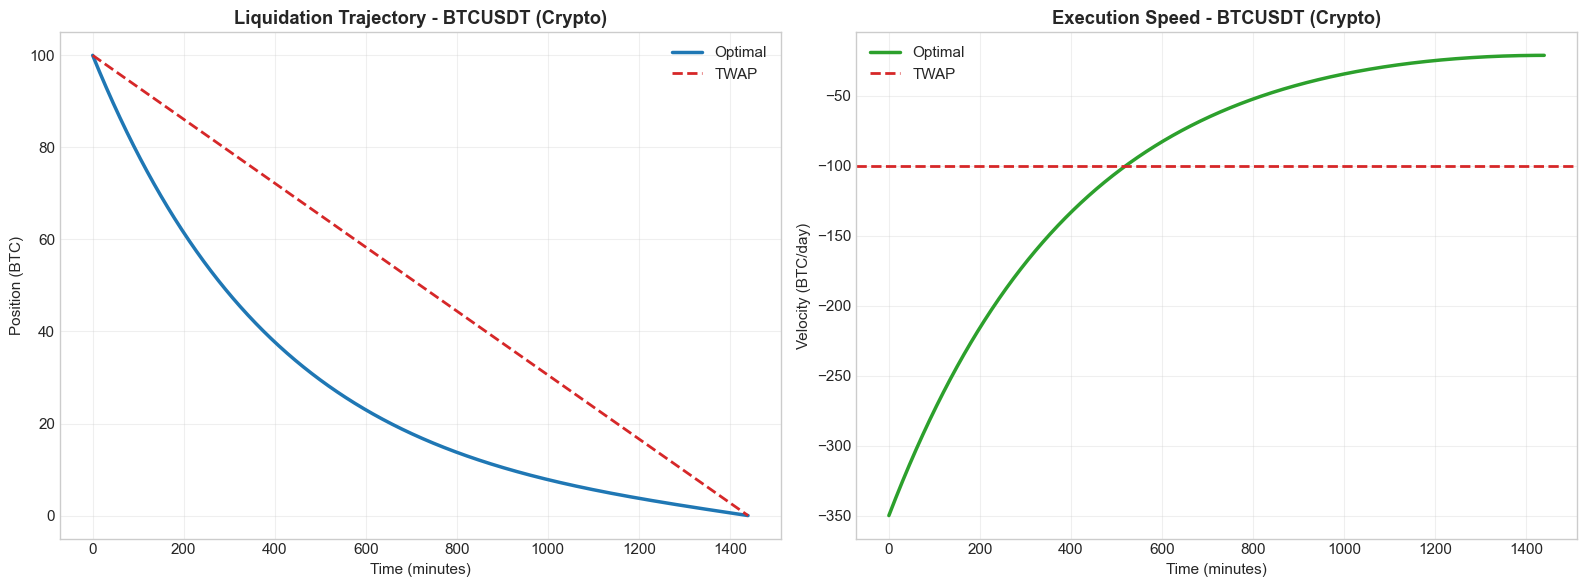

In [151]:
if crypto_available:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Position trajectory
    ax = axes[0]
    ax.plot(t_opt_crypto * N_crypto, q_opt_crypto, label='Optimal', color='tab:blue', linewidth=2.5)
    ax.plot(t_twap_crypto * N_crypto, q_twap_crypto, '--', label='TWAP', color='tab:red', linewidth=2)
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Position (BTC)')
    ax.set_title(f'Liquidation Trajectory - {SYMBOL_CRYPTO} (Crypto)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Velocity
    ax = axes[1]
    ax.plot(t_opt_crypto * N_crypto, v_opt_crypto, label='Optimal', color='tab:green', linewidth=2.5)
    ax.axhline(v_twap_crypto[0], color='tab:red', linestyle='--', linewidth=2, label='TWAP')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Velocity (BTC/day)')
    ax.set_title(f'Execution Speed - {SYMBOL_CRYPTO} (Crypto)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 2.4 Cost Analysis for Crypto

In [152]:
if crypto_available:
    # Compute costs (model already includes psi)
    costs_opt_crypto = model_crypto.compute_costs(q0_crypto, T_crypto, N_crypto, 'optimal')
    costs_twap_crypto = model_crypto.compute_costs(q0_crypto, T_crypto, N_crypto, 'twap')
    
    # Display
    print(f"\n Cost Comparison - {SYMBOL_CRYPTO} (Crypto)")
    print("="*70)
    print(f"Model: QUADRATIC (Almgren-Chriss 2001)")
    print(f"η = {eta_crypto:.4f} (calibrated for quadratic model)")
    print(f"k = {k_crypto:.2e}")
    
    notional_crypto = q0_crypto * S0_crypto
    
    # =========================================================================
    # COST CONVERSION
    # =========================================================================
    # All costs from compute_costs are in units that give $ when × S₀
    # To convert to bps: (cost / q₀) × 10000
    # =========================================================================
    
    print(f"\nIn dollars (notional = ${notional_crypto:,.0f}):")
    print("-"*70)
    print(f"{'Component':<25} {'Optimal':>15} {'TWAP':>15} {'Difference':>15}")
    print("-"*70)
    
    # Multiply by S0 to get dollars
    fees_opt_dollars = costs_opt_crypto['transaction_fees'] * S0_crypto
    fees_twap_dollars = costs_twap_crypto['transaction_fees'] * S0_crypto
    
    exec_opt_dollars = costs_opt_crypto['execution_cost'] * S0_crypto
    exec_twap_dollars = costs_twap_crypto['execution_cost'] * S0_crypto
    
    perm_opt_dollars = costs_opt_crypto['permanent_impact'] * S0_crypto
    perm_twap_dollars = costs_twap_crypto['permanent_impact'] * S0_crypto
    
    risk_opt_dollars = costs_opt_crypto['timing_risk'] * S0_crypto
    risk_twap_dollars = costs_twap_crypto['timing_risk'] * S0_crypto
    
    total_opt_dollars = costs_opt_crypto['total_cost'] * S0_crypto
    total_twap_dollars = costs_twap_crypto['total_cost'] * S0_crypto
    
    print(f"{'Transaction Fees':<25} ${fees_opt_dollars:>13,.0f} ${fees_twap_dollars:>13,.0f} ${fees_twap_dollars - fees_opt_dollars:>13,.0f}")
    print(f"{'Execution Cost (temp)':<25} ${exec_opt_dollars:>13,.0f} ${exec_twap_dollars:>13,.0f} ${exec_twap_dollars - exec_opt_dollars:>13,.0f}")
    print(f"{'Permanent Impact':<25} ${perm_opt_dollars:>13,.0f} ${perm_twap_dollars:>13,.0f} ${perm_twap_dollars - perm_opt_dollars:>13,.0f}")
    print(f"{'Timing Risk':<25} ${risk_opt_dollars:>13,.0f} ${risk_twap_dollars:>13,.0f} ${risk_twap_dollars - risk_opt_dollars:>13,.0f}")
    print("-"*70)
    print(f"{'TOTAL':<25} ${total_opt_dollars:>13,.0f} ${total_twap_dollars:>13,.0f} ${total_twap_dollars - total_opt_dollars:>13,.0f}")
    print("-"*70)
    
    # In bps (relative to notional)
    fees_bps = (costs_opt_crypto['transaction_fees'] / q0_crypto) * 10000
    exec_opt_bps = (costs_opt_crypto['execution_cost'] / q0_crypto) * 10000
    exec_twap_bps = (costs_twap_crypto['execution_cost'] / q0_crypto) * 10000
    perm_opt_bps = (costs_opt_crypto['permanent_impact'] / q0_crypto) * 10000
    perm_twap_bps = (costs_twap_crypto['permanent_impact'] / q0_crypto) * 10000
    risk_opt_bps = (costs_opt_crypto['timing_risk'] / q0_crypto) * 10000
    risk_twap_bps = (costs_twap_crypto['timing_risk'] / q0_crypto) * 10000
    
    opt_bps_crypto = (costs_opt_crypto['total_cost'] / q0_crypto) * 10000
    twap_bps_crypto = (costs_twap_crypto['total_cost'] / q0_crypto) * 10000
    
    print(f"\nIn basis points (of notional):")
    print("-"*70)
    print(f"{'Component':<25} {'Optimal':>15} {'TWAP':>15}")
    print("-"*70)
    print(f"{'Transaction Fees':<25} {fees_bps:>14.1f} {fees_bps:>14.1f}")
    print(f"{'Execution Cost (temp)':<25} {exec_opt_bps:>14.2f} {exec_twap_bps:>14.2f}")
    print(f"{'Permanent Impact':<25} {perm_opt_bps:>14.2f} {perm_twap_bps:>14.2f}")
    print(f"{'Timing Risk':<25} {risk_opt_bps:>14.2f} {risk_twap_bps:>14.2f}")
    print("-"*70)
    print(f"{'TOTAL':<25} {opt_bps_crypto:>14.2f} {twap_bps_crypto:>14.2f}")
    print("-"*70)
    
    print(f"\n Summary:")
    print(f"   Optimal strategy: {opt_bps_crypto:.2f} bps = ${total_opt_dollars:,.0f}")
    print(f"   TWAP strategy:    {twap_bps_crypto:.2f} bps = ${total_twap_dollars:,.0f}")
    print(f"   Optimization gain: {twap_bps_crypto - opt_bps_crypto:.2f} bps ({(twap_bps_crypto - opt_bps_crypto)/twap_bps_crypto*100:.1f}%)")
    
    # Sanity check
    print(f"\n Sanity check:")
    rho_participation = q0_crypto / V_crypto
    print(f"   Participation rate: ρ = {q0_crypto}/{V_crypto:.0f} = {rho_participation*100:.2f}%")
    print(f"   Expected fees: {psi_crypto*10000:.0f} bps → Got: {fees_bps:.1f} bps ")
    
    # Temporary impact verification
    v_twap = q0_crypto / T_crypto
    exec_expected = eta_crypto * v_twap**2 / V_crypto * T_crypto
    exec_expected_bps = exec_expected / q0_crypto * 10000
    print(f"   Expected temp impact: η×v²/V×T = {eta_crypto:.4f}×{v_twap:.0f}²/{V_crypto:.0f}×{T_crypto} = {exec_expected:.4f} → {exec_expected_bps:.2f} bps ")
    
    # Permanent impact verification  
    perm_expected = k_crypto * q0_crypto**2 / 2
    perm_expected_bps = perm_expected / q0_crypto * 10000
    print(f"   Expected perm impact: k×q₀²/2 = {k_crypto:.2e}×{q0_crypto}²/2 = {perm_expected:.4f} → {perm_expected_bps:.2f} bps ")


 Cost Comparison - BTCUSDT (Crypto)
Model: QUADRATIC (Almgren-Chriss 2001)
η = 0.0280 (calibrated for quadratic model)
k = 2.14e-06

In dollars (notional = $9,040,834):
----------------------------------------------------------------------
Component                         Optimal            TWAP      Difference
----------------------------------------------------------------------
Transaction Fees          $        9,041 $        9,041 $            0
Execution Cost (temp)     $        1,776 $        1,000 $         -776
Permanent Impact          $          966 $          966 $            0
Timing Risk               $        1,731 $        4,067 $        2,336
----------------------------------------------------------------------
TOTAL                     $       13,514 $       15,075 $        1,561
----------------------------------------------------------------------

In basis points (of notional):
----------------------------------------------------------------------
Component     

---
# Summary & Comparison

In [153]:
print("="*70)
print("SUMMARY - STOCKS vs CRYPTO")
print("="*70)

if stocks_available and crypto_available:
    print(f"\n{'Metric':<30} {'Stock (AAPL)':<25} {'Crypto (BTCUSDT)':<25}")
    print("-"*70)
    print(f"{'Volatility (annual)':<30} {sigma_stock*100:>6.2f}% {sigma_crypto*100:>24.2f}%")
    print(f"{'Daily Volume':<30} {V_stock:>22,.0f} {V_crypto:>27.2f}")
    print(f"{'Price':<30} ${S0_stock:>23.2f} ${S0_crypto:>26.2f}")
    print(f"{'Position Size':<30} {q0_stock:>16,} shares {q0_crypto:>20.0f} BTC")
    print(f"{'Trading Hours':<30} {N_stock:>14} min (6.5h) {N_crypto:>16} min (24h)")
    print(f"{'Notional':<30} ${q0_stock*S0_stock:>21,.0f} ${q0_crypto*S0_crypto:>24,.0f}")
    print(f"\n{'Optimal Cost (bps)':<30} {opt_bps_stock:>24.2f} {opt_bps_crypto:>27.2f}")
    print(f"{'TWAP Cost (bps)':<30} {twap_bps_stock:>24.2f} {twap_bps_crypto:>27.2f}")
    print(f"{'Optimization Gain (%)':<30} {(twap_bps_stock-opt_bps_stock)/twap_bps_stock*100:>23.1f}% {(twap_bps_crypto-opt_bps_crypto)/twap_bps_crypto*100:>26.1f}%")
elif crypto_available:
    print(f"\nOnly crypto data analyzed:")
    print(f"   {SYMBOL_CRYPTO}: Optimal = {opt_bps_crypto:.2f} bps, TWAP = {twap_bps_crypto:.2f} bps")
    print(f"   Gain: {(twap_bps_crypto-opt_bps_crypto)/twap_bps_crypto*100:.1f}%")
else:
    print("\n No data available for analysis")

SUMMARY - STOCKS vs CRYPTO

Only crypto data analyzed:
   BTCUSDT: Optimal = 14.95 bps, TWAP = 16.67 bps
   Gain: 10.4%


## Save Results

In [154]:
results = {
    'execution_date': datetime.now().isoformat(),
    'model': 'Almgren-Chriss Quadratic'
}

if stocks_available:
    results['stock'] = {
        'ticker': TICKER_STOCK,
        'parameters': {'sigma': sigma_stock, 'V': V_stock, 'S0': S0_stock, 'q0': q0_stock, 'N': N_stock},
        'costs_optimal_bps': opt_bps_stock,
        'costs_twap_bps': twap_bps_stock
    }

if crypto_available:
    results['crypto'] = {
        'symbol': SYMBOL_CRYPTO,
        'parameters': {'sigma': sigma_crypto, 'V': V_crypto, 'S0': S0_crypto, 'q0': q0_crypto, 'N': N_crypto},
        'costs_optimal_bps': opt_bps_crypto,
        'costs_twap_bps': twap_bps_crypto
    }

with open('results/02_almgren_chriss_basic_results.json', 'w') as f:
    json.dump(results, f, indent=2, default=float)

print(" Results saved to results/02_almgren_chriss_basic_results.json")

 Results saved to results/02_almgren_chriss_basic_results.json
